Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [45]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
       'ShortPassing',  'Dribbling',  
        'BallControl',  'SprintSpeed', 
       'Reactions',    'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision'
]
# PLAYER_ATTRIBUTES = [ 'shooting','ShortPassing','Dribbling','BallControl',
#                      'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']
# PLAYER_ATTRIBUTES = [ 'Finishing',   'LongShots','ShotPower',   'Volleys',   'FKAccuracy',  'HeadingAccuracy',
#                       'Positioning', 'Vision' ,'ShortPassing','LongPassing',
#                      'BallControl','Dribbling', 
#                       'Acceleration', 'SprintSpeed', 'Agility','Reactions', 
#                       'Balance', 'Stamina','Jumping','Composure']


In [46]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [47]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [48]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,17.502664,31.843694,-3.713144,29.699822,2.902309,31.346359,27.808171,36.721137,27.376554,33.410894
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,13.717460,28.879365,9.719048,32.160635,11.850794,28.977778,15.171429,34.958730,26.241270,33.225397
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,12.830986,20.380282,8.190781,16.056082,9.382843,16.982074,15.554417,20.797695,15.592830,15.660265
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,14.938728,19.894798,2.326590,19.198382,9.764162,23.989595,23.932948,24.187283,20.012717,22.174181
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,14.938728,19.894798,0.326590,20.598382,16.764162,26.989595,12.932948,26.187283,14.012717,26.840848


# 

In [49]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [50]:
df = df[df.winger == 0]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
75.0    29
78.0    26
77.0    23
73.0    22
74.0    19
76.0    19
72.0    14
71.0    13
81.0    13
80.0    12
70.0    12
79.0    12
68.0    12
69.0    11
84.0    11
67.0    10
83.0     9
82.0     9
64.0     8
66.0     7
88.0     4
87.0     4
89.0     3
65.0     2
86.0     2
62.0     2
63.0     2
90.0     1
61.0     1
85.0     1
92.0     1
91.0     1
57.0     1
Name: count, dtype: int64


In [51]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,drop,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,72.0,72.0,drop,ST
253002,G. Raspadori,2022,21.0,21.0,22.0,88.0,88.0,74.0,79.0,79.0,valid,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,24.0,88.0,88.0,76.0,81.0,81.0,train,ST


In [52]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [53]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [54]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

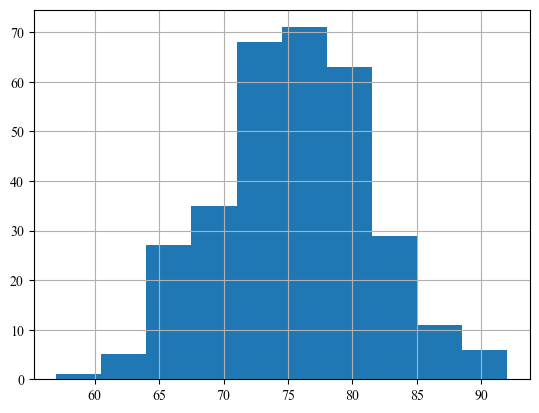

In [55]:
df['target'].hist()

In [56]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [57]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense',
       'overall_age_ratio', 'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Strength',
       'age_based_React

In [58]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [59]:
y_train.describe()

count    154.000000
mean      75.876623
std        5.575774
min       57.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       89.000000
Name: target, dtype: float64

In [60]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [61]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [62]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [63]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


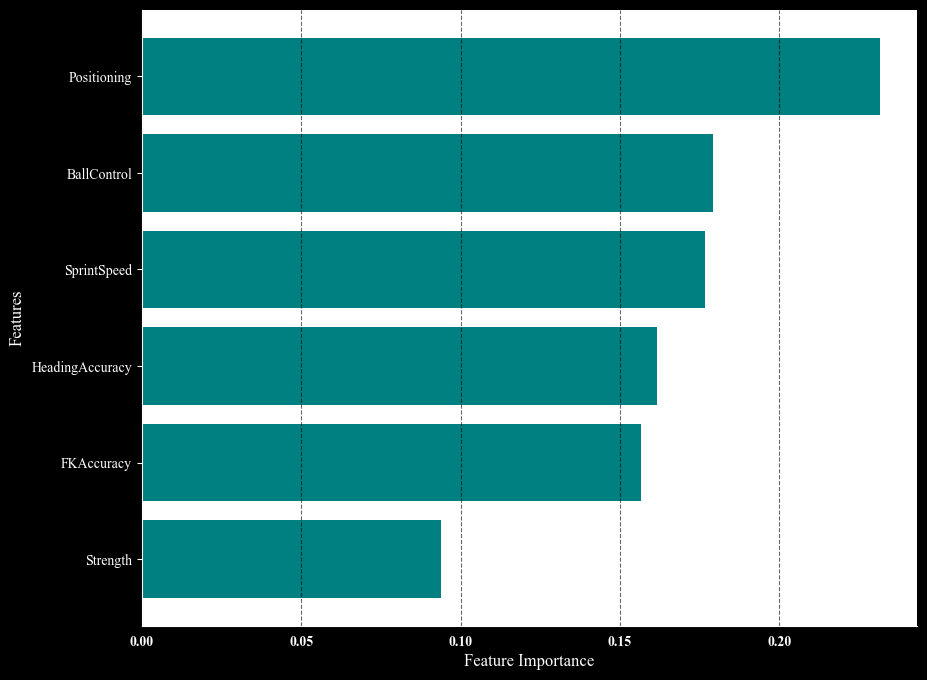

100%|██████████| 30/30 [00:01<00:00, 27.95it/s]


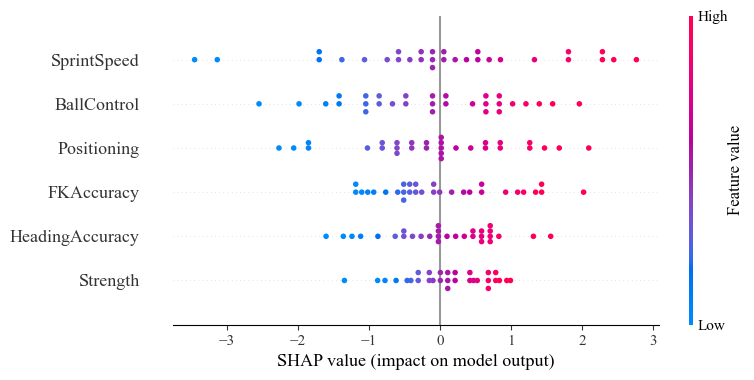

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Huber Regression training----->


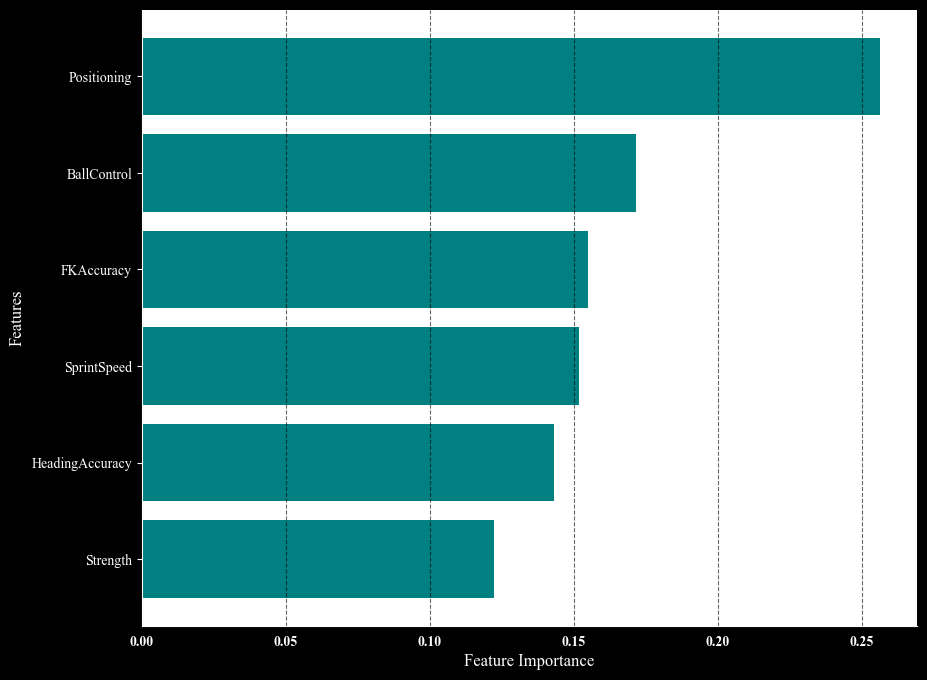

100%|██████████| 30/30 [00:00<00:00, 33.73it/s]


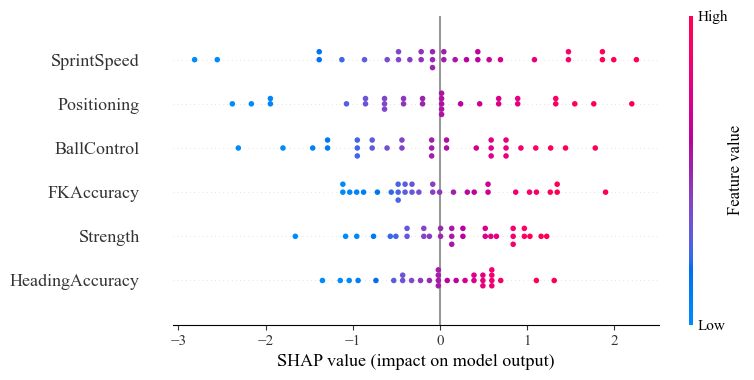

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Linear Regression training----->


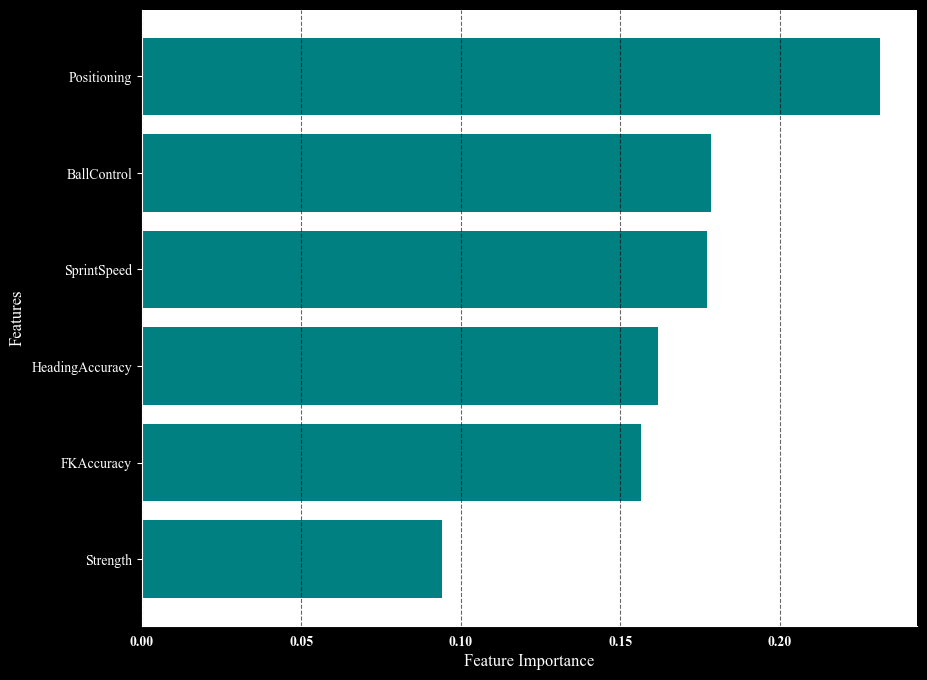

100%|██████████| 30/30 [00:01<00:00, 26.10it/s]


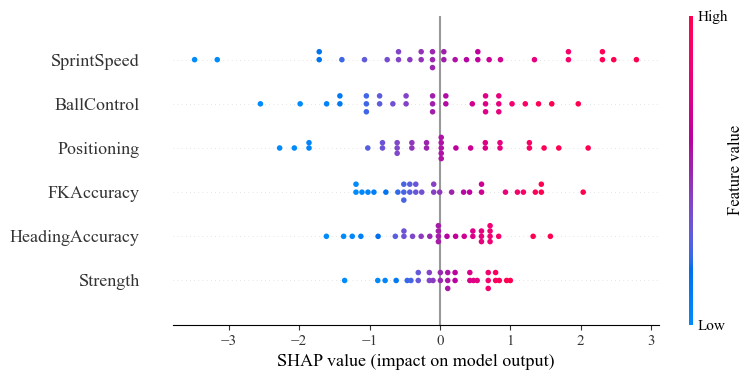

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Model: Ridge Regression
Mean Squared Error: 15.63
Mean Absolute Error: 3.25
R2 Score: 0.48

Model: Huber Regression
Mean Squared Error: 15.57
Mean Absolute Error: 3.26
R2 Score: 0.48

Model: Linear Regression
Mean Squared Error: 15.62
Mean Absolute Error: 3.25
R2 Score: 0.48



In [64]:
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())
        from sklearn.feature_selection import SelectFromModel
        
        # featres = X_train_scaled_df.columns
        if AUTO_FEATURE_SELECT == 'AUTO':
            sfm = SelectFromModel(model).fit(X_train_scaled_df, y_train)
            features = X_train_scaled_df.columns[sfm.get_support()]
        elif AUTO_FEATURE_SELECT in  ['backward','forward']:
            from sklearn.feature_selection import SequentialFeatureSelector
            sfm = SequentialFeatureSelector(
                model, direction=AUTO_FEATURE_SELECT
            ).fit(X_train_scaled_df, y_train)
            features = X_train_scaled_df.columns[sfm.get_support()]
        else:
            features = X_train_scaled_df.columns
        

        model.fit(X_train_scaled_df[features], y_train)
       
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [65]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

In [66]:
explainer


In [67]:
explainer

# evaluate Model

In [68]:
X_train.describe()

,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,46.454545,62.701299,61.545455,69.461039,69.616883,77.753247,65.279221,64.298701,61.610390,48.357143,68.181818,58.298701
std,12.626402,9.051869,8.035941,7.710559,6.495044,7.541009,7.992232,12.318820,7.451202,13.834067,7.593818,9.377438
min,22.000000,33.000000,41.000000,47.000000,51.000000,55.000000,45.000000,27.000000,42.000000,26.000000,51.000000,34.000000
25%,37.000000,58.000000,56.250000,64.000000,66.000000,74.000000,59.000000,57.250000,56.000000,35.000000,62.000000,52.000000
50%,43.000000,63.000000,61.000000,70.000000,70.000000,77.000000,65.500000,65.000000,61.500000,48.000000,68.000000,58.500000
75%,56.000000,69.000000,67.000000,75.000000,74.000000,83.750000,71.000000,73.750000,66.750000,58.000000,74.000000,64.000000
max,75.000000,83.000000,81.000000,87.000000,87.000000,92.000000,86.000000,91.000000,82.000000,79.000000,86.000000,82.000000


In [69]:
y_test.describe()

count    59.000000
mean     73.338983
std       5.504262
min      63.000000
25%      69.000000
50%      73.000000
75%      76.500000
max      91.000000
Name: target, dtype: float64

In [70]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [71]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

59

<Axes: >

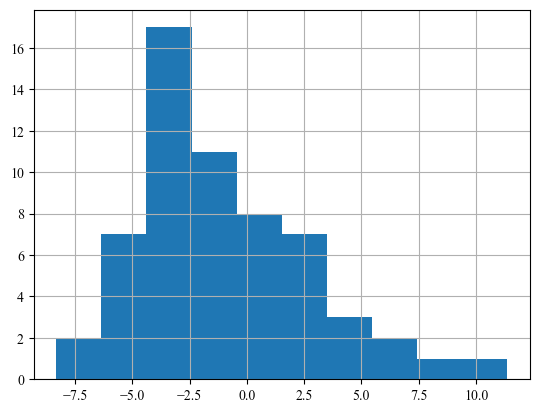

In [72]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

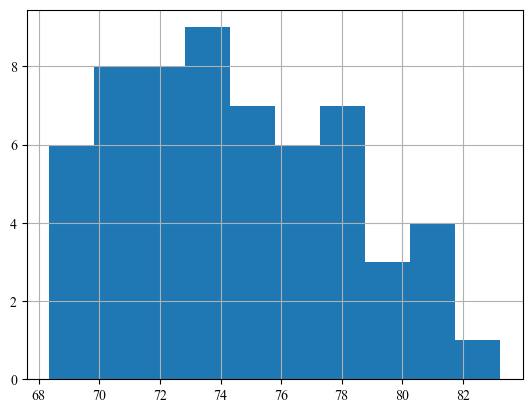

In [73]:
result_df.sort_values(ascending=False).hist()

In [74]:
(y_test-result_df).describe()

count    59.000000
mean     -1.098577
std       3.821911
min      -8.320805
25%      -3.586429
50%      -2.056472
75%       0.553321
max      11.361549
dtype: float64

In [75]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,
251852,K. Adeyemi,2021,59.0,62.0,67.0,75.0,73.0,88.0,63.0,56.0,69.0,36.0,63.0,66.0
241721,Rafael Leão,2020,58.0,58.0,67.0,77.0,75.0,86.0,73.0,77.0,62.0,59.0,78.0,69.0
246191,J. Álvarez,2020,66.0,60.0,63.0,68.0,72.0,78.0,66.0,40.0,59.0,32.0,65.0,60.0
239085,E. Håland,2020,51.0,62.0,67.0,72.0,74.0,83.0,72.0,84.0,62.0,81.0,73.0,57.0
248805,Sergio Camello,2020,34.0,61.0,62.0,65.0,66.0,64.0,64.0,47.0,60.0,27.0,67.0,54.0
256853,M. Tillman,2021,32.0,59.0,57.0,62.0,62.0,65.0,54.0,59.0,59.0,41.0,57.0,53.0
246430,D. Vlahović,2021,37.0,68.0,60.0,70.0,72.0,66.0,68.0,68.0,64.0,50.0,74.0,54.0
243630,J. David,2020,34.0,71.0,72.0,74.0,76.0,83.0,70.0,68.0,68.0,25.0,70.0,71.0
238616,Pedro Neto,2020,40.0,51.0,60.0,70.0,71.0,78.0,65.0,40.0,62.0,32.0,64.0,56.0


In [76]:
y_test[outlier]

ID      Name            FIFA
251852  K. Adeyemi      2021    80.0
241721  Rafael Leão     2020    86.0
246191  J. Álvarez      2020    80.0
239085  E. Håland       2020    91.0
248805  Sergio Camello  2020    75.0
256853  M. Tillman      2021    74.0
246430  D. Vlahović     2021    84.0
243630  J. David        2020    81.0
238616  Pedro Neto      2020    78.0
Name: target, dtype: float64

In [77]:
result_df[outlier]

ID      Name            FIFA
251852  K. Adeyemi      2021    76.776373
241721  Rafael Leão     2020    80.987200
246191  J. Álvarez      2020    75.068524
239085  E. Håland       2020    79.638451
248805  Sergio Camello  2020    70.676145
256853  M. Tillman      2021    68.348026
246430  D. Vlahović     2021    75.785219
243630  J. David        2020    77.872145
238616  Pedro Neto      2020    71.698254
dtype: float64

In [78]:
(y_test/result_df).describe()

count    59.000000
mean      0.985012
std       0.050999
min       0.884946
25%       0.953438
50%       0.971365
75%       1.007357
max       1.142664
dtype: float64

In [79]:
(y_test/result_df).describe()

count    59.000000
mean      0.985012
std       0.050999
min       0.884946
25%       0.953438
50%       0.971365
75%       1.007357
max       1.142664
dtype: float64

In [80]:
np.corrcoef(y_test,result_df)

array([[1.       , 0.7221097],
       [0.7221097, 1.       ]])

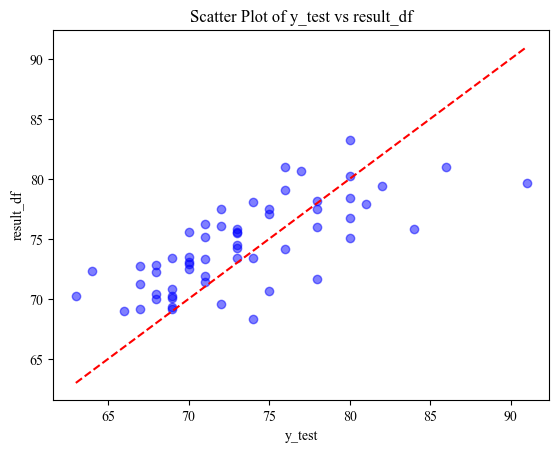

In [81]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [82]:
result_df = result_df.sort_values(ascending=False)

In [83]:
result_df.head(50)

ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.229889
241721  Rafael Leão       2020    80.987200
245158  L. Suárez         2021    80.974639
235866  C. Kouamé         2020    80.692959
231447  D. Malen          2020    80.267325
239085  E. Håland         2020    79.638451
253072  D. Núñez          2021    79.379161
241522  J. Wind           2021    79.041938
246186  Arthur Cabral     2021    78.414271
251470  C. De Ketelaere   2021    78.172884
244797  P. Musa           2021    78.068423
243630  J. David          2020    77.872145
245940  S. Wamangituka    2020    77.515931
244622  Puado             2020    77.496340
251756  R. Nteka          2021    77.489608
246762  S. Koita          2021    77.056472
251852  K. Adeyemi        2021    76.776373
245396  V. Supryaga       2021    76.251332
225668  K. Grant          2020    76.087974
246147  M. Greenwood      2020    75.974454
252042  João Pedro        2021    75.857440
246430  D. Vlahović       2021    75.785219
2

In [84]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.229889
241721  Rafael Leão       2020    80.987200
231447  D. Malen          2020    80.267325
dtype: float64

In [85]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

7


ID      Name           FIFA
239085  E. Håland      2020    79.638451
253072  D. Núñez       2021    79.379161
246186  Arthur Cabral  2021    78.414271
243630  J. David       2020    77.872145
251852  K. Adeyemi     2021    76.776373
246430  D. Vlahović    2021    75.785219
246191  J. Álvarez     2020    75.068524
dtype: float64

In [86]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

4


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.229889
245158  L. Suárez         2021    80.974639
235866  C. Kouamé         2020    80.692959
231447  D. Malen          2020    80.267325
dtype: float64

In [87]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

47


ID      Name             FIFA
250961  J. Zirkzee       2020    73.422069
238460  R. Brewster      2020    73.479900
241487  J. Ferreira      2020    74.157393
252037  Fábio Silva      2020    74.206552
238900  E. Demirović     2021    74.484799
251105  D. Joveljić      2020    75.162539
243315  Dani Gómez       2020    75.503293
247888  S. Esposito      2021    75.576211
239025  I. Niane         2020    75.604912
252042  João Pedro       2021    75.857440
246147  M. Greenwood     2020    75.974454
225668  K. Grant         2020    76.087974
245396  V. Supryaga      2021    76.251332
246762  S. Koita         2021    77.056472
251756  R. Nteka         2021    77.489608
244622  Puado            2020    77.496340
245940  S. Wamangituka   2020    77.515931
244797  P. Musa          2021    78.068423
251470  C. De Ketelaere  2021    78.172884
241522  J. Wind          2021    79.041938
dtype: float64

In [88]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.78      0.61      0.68        41
        True       0.41      0.61      0.49        18

    accuracy                           0.61        59
   macro avg       0.59      0.61      0.59        59
weighted avg       0.67      0.61      0.63        59

